In [1]:
import collections
import datetime
import os
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sys.path.append(os.path.abspath('../Data'))
import queries

In [2]:
# server = 'VT1'
# schema = 'SRSHNKDIG'

# server = 'MA3'
# schema = 'SRSANBDIG'

server = 'VT3'
schema = 'WCS01600'

features = queries.get_profit_ces_by_day(server, schema)
features = features.drop(columns='CES')
features.describe().transpose()

count           mean           std         min         25%  \
TYEAR   1351.0    2018.111029      1.489058   2016.0000    2017.000   
TMON    1351.0       6.365655      3.494691      1.0000       3.000   
TDAY    1351.0      15.735011      8.739317      1.0000       8.000   
PROFIT  1351.0  216773.125104  81466.039617 -15223.8972  173014.657   

               50%           75%          max  
TYEAR     2018.000    2019.00000    2021.0000  
TMON         6.000       9.00000      12.0000  
TDAY        16.000      23.00000      31.0000  
PROFIT  219606.999  268404.33055  549121.7957

In [3]:
features.head(20)

TYEAR  TMON  TDAY       PROFIT
0   2016.0   1.0   4.0  117472.2012
1   2016.0   1.0   5.0  140594.5397
2   2016.0   1.0   6.0  139909.6150
3   2016.0   1.0   7.0  190749.8408
4   2016.0   1.0   8.0  175706.8981
5   2016.0   1.0  11.0  125811.4850
6   2016.0   1.0  12.0  161062.3397
7   2016.0   1.0  13.0  146233.5833
8   2016.0   1.0  14.0  189694.3337
9   2016.0   1.0  15.0  164590.4520
10  2016.0   1.0  18.0  113204.3443
11  2016.0   1.0  19.0  155728.7654
12  2016.0   1.0  20.0  153409.0856
13  2016.0   1.0  21.0  178143.1604
14  2016.0   1.0  22.0  173919.0123
15  2016.0   1.0  25.0  127364.5960
16  2016.0   1.0  26.0  153897.7958
17  2016.0   1.0  27.0  167097.7597
18  2016.0   1.0  28.0  196854.7193
19  2016.0   1.0  29.0  189654.7587

In [5]:
Models = collections.namedtuple('Models', ['MODEL', 'PARAMS'])
Model_Params = collections.namedtuple('Model_Params', ['LOSS', 'OPTIMIZER', 
                                      'EPOCHS', 'CALLBACKS', 'VERBOSE'])

In [6]:
class schema_ML():
    def __init__(self, schema, df):
        
        # Store initial data.
        self.schema = schema
        self.df_initial = df
        
        self.models = {}
        self.model_params = Model_Params('mae', 'adam', 500, [], 2)
        
        self.train_performance = {}
        self.test_performance = {}
        self.mfe = {}
        self.mae = {}
        self.mse = {}
        self.rmse = {}
        
        # Preprocess data.
        self.preprocess()
        
    def preprocess(self):
        
        # Reference DF
        df = self.df_initial
        
        # Combine individual date columns to single index
        df = df.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH', 'TDAY':'DAY'})
        df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
        df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])
        df.set_index('DATE', inplace=True)
        
        self.df = df
        df.plot(subplots=True, title='Initial Data') 
        
        plot_acf(df['PROFIT'], lags=365)
        plot_pacf(df['PROFIT'], lags=365)
        
        # Insert zeros for missing dates
        df = self.add_missing_dates(df)
        self.df = df
        df.plot(subplots=True, title='Initial Data') 
        
        # Add daily average columns
        # df = self.add_daily_averages(df)
        
        # Duplicate data
        df = self.duplicate(df)
        df = self.duplicate(df)
        df.plot(subplots=True, title='Duplicated Data') 
        
        # Add differencing
        df = self.add_differencing(df)
        self.differenced_df = df
        df.plot(subplots=True, title='Added Differencing')
        
        # Normalize using scaler
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled = scaler.fit_transform(df.values)
        df = pd.DataFrame(scaled, columns=df.columns)
        df.plot(subplots=True, title='Added Normalization')
        self.normalized_df = df
        self.scaler = scaler
        
        # Split into train/val/test
        train_df, test_df = self.train_test_split(df)
        
        self.train_df = train_df
        self.test_df = test_df
        
    def add_missing_dates(self, df):
        missing_dates = pd.date_range(start=df.index[0], end=df.index[-1]).difference(df.index)
        n = len(missing_dates)
        m = len(df.columns)
        missing_dates_data = np.zeros((n,m))
        missing_dates_df = pd.DataFrame(missing_dates_data, index=missing_dates, columns=df.columns)
        dfs = [df, missing_dates_df]
        df = pd.concat(dfs)
        df['Date'] = df.index
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        
        return df
    
    def add_daily_averages(self, df):
        indexes = df.index.to_numpy()
        data = df.to_numpy()
        columns = list(df)

        rows = data.shape[0]
        cols = data.shape[1]
        avgcol_names = []
        avgcols = []
        
        for y in range(0, cols):
            avgcol = np.zeros((rows,1))
            col = data[:,y]
            
            for d in range(0, 365):
                day_d_entries = col[d: len(col): 365]
                day_d_entries[day_d_entries == 0] = np.nan
                avg = np.nanmean(day_d_entries)
                avgcol[d: len(col): 365] = avg
                
            avgcols.append(avgcol)
            avgcol_names.append(columns[y] + '_DAY_AVG')
        
        for newcol in avgcols:
            data = np.concatenate((data, newcol), axis=1)
            
        df = pd.DataFrame(data, index=df.index, columns=columns + avgcol_names).fillna(0)
        return df
    
    def duplicate(self, df):
    
        first_date = df.index[0]
        today = datetime.datetime.today()
        
        if first_date.day > today.day and first_date.month > today.month:
            target_year = today.year - 1
        else:
            target_year = today.year
            
        target_date = datetime.datetime(target_year, first_date.month, first_date.day - 1)
        to_append = df.copy()[:target_date]
        year_diff = target_year - first_date.year

        to_append.drop(to_append.loc[(to_append.index.month == 2) & (to_append.index.day == 29)].index, inplace=True)
        to_append.index = to_append.index.to_series().replace(to_append.index.to_series().apply(lambda dt: dt.replace(year=dt.year-year_diff)))
        
        return pd.concat([to_append, df])
        
    def add_differencing(self, df):
        df = df.diff(365)
        
        return df.dropna()
        
    def train_test_split(self, df):
        n = len(df)
        pct_test = (np.log2(n/2) * 0.01)
        num_test = int(n * pct_test)
        num_train = n - num_test
        
        train = df[:num_train]
        test = df[num_train:]
        
        return train, test
    
    def add_lag(self, df):
        lags = [1, 7, 14]
        cols = df.columns
        
        lagged = df.assign(**{
            '{} (t-{})'.format(col, t): df[col].shift(t)
            for t in lags
            for col in cols
        })
        
        return lagged.dropna()
    
    def reshape(self, X):
        X = X.values.reshape((X.shape[0], 1, X.shape[1]))
        
        return X
    
    def get_train_and_test(self, pred_col):
        train = self.train_df
        test = self.test_df

        train = self.add_lag(train)
        test = self.add_lag(test)

#         X_train = train.filter(regex='^(?!' + pred_col + '$)')
        X_train = train.filter(regex='t-')
        Y_train = train.filter(regex='^(' + pred_col + '$)')
#         X_test = test.filter(regex='^(?!' + pred_col + '$)')
        X_test = test.filter(regex='t-')
        Y_test = test.filter(regex='^(' + pred_col + '$)')
    
        X_train, X_test = self.reshape(X_train), self.reshape(X_test)
        
        return X_train, Y_train, X_test, Y_test
        
    def evaluate_and_plot(self, pred_col='PROFIT', model_name='', model=None, model_params=None):
        
        if model is not None:
        
            # Add model to dictionary
            if model_params == None:
                model_params = self.model_params

            if model is not None:
                self.models[model_name] = Models(model, model_params)

            # Get training and validation data
            X_train, Y_train, X_test, Y_test = self.get_train_and_test(pred_col)

            # Compile model    
            model.compile(loss=model_params.LOSS, optimizer=model_params.OPTIMIZER)
            
            # Fit model to training data
            history = model.fit(X_train, Y_train, epochs=model_params.EPOCHS, 
                                callbacks=model_params.CALLBACKS, validation_data=(X_test, Y_test),
                                verbose=model_params.VERBOSE, shuffle=False)

            # Add validation information to dictionary
            self.train_performance[model_name] = min(history.history['loss'])
            self.test_performance[model_name] = min(history.history['val_loss'])
            
            # Plot train vs. val losses
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='val')
            plt.title('Training Loss vs. Test Loss')
            plt.xlabel('# of Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
            
            # Calculate performance metrics and add to dictionaries
            expected = Y_test.values
            predicted = model(X_test)
            forecast_errors = [expected[i] - predicted[i] for i in range(len(expected))]
            
            mfe = np.mean(forecast_errors)
            mae = mean_absolute_error(expected, predicted)
            mse = mean_squared_error(expected, predicted)
            rmse = np.sqrt(mse)
            
            self.mfe[model_name] = mfe
            self.mae[model_name] = mae
            self.mse[model_name] = mse
            self.rmse[model_name] = rmse
            
            # Plot expected vs predicted
            plt.figure(figsize=(40,8))
            diff = self.test_df.index.shape[0] - expected.shape[0]
            plt.plot(self.test_df.index[diff:], expected, label='Expected', marker='.', zorder=-10)
            plt.scatter(self.test_df.index[diff:], predicted, label='Predicted', edgecolors='k', c='#2ca02c', s=64)
            plt.show()
            
            ### TEST - Inverse transform scaler ###
            
#             scaler = self.scaler
#             df_one = self.train_df
#             df_three = self.test_df
#             expected_df = pd.DataFrame(expected, index=Y_test.index, columns=Y_test.columns)
#             predicted_df = pd.DataFrame(predicted.numpy(), index=Y_test.index, columns=Y_test.columns)
            
#             expected_frames = [df_one[['PROFIT', 'CES']], expected_df, df_three[['PROFIT', 'CES']]]
#             predicted_frames = [df_one[['PROFIT', 'CES']], predicted_df, df_three[['PROFIT', 'CES']]]
#             full_expected_df = pd.concat(expected_frames)
#             full_predicted_df = pd.concat(predicted_frames)
            
#             inverse_expected = scaler.inverse_transform(full_expected_df)
#             inverse_predicted = scaler.inverse_transform(full_predicted_df)
            
#             indexes = df_one.index.union(expected_df.index).union(df_three.index)      
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=indexes)
#             print(inverse_expected_df)
            
            
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=self.df_initial.index, columns=['PROFIT', 'CES'])
#             inverse_predicted_df = pd.DataFrame(inverse_predicted, index=self.df_initial.index, columns=['PROFIT', 'CES'])
            
            ### END TEST ###
            
            
        # Plot specified columns and results
        
        
    def performance_metrics(self):
        
        # Convert dictionarites to single dataframe
        mfe_df = pd.DataFrame.from_dict(self.mfe, columns=['MFE'], orient='index')
        mae_df = pd.DataFrame.from_dict(self.mae, columns=['MAE'], orient='index')
        mse_df = pd.DataFrame.from_dict(self.mse, columns=['MSE'], orient='index')
        rmse_df = pd.DataFrame.from_dict(self.rmse, columns=['RMSE'], orient='index')
        performance_df = mfe_df.join(mae_df).join(mse_df).join(rmse_df)
        performance_df = performance_df.transpose()
        
        performance_df.plot(kind='bar')
        plt.show()
        print(performance_df)

        

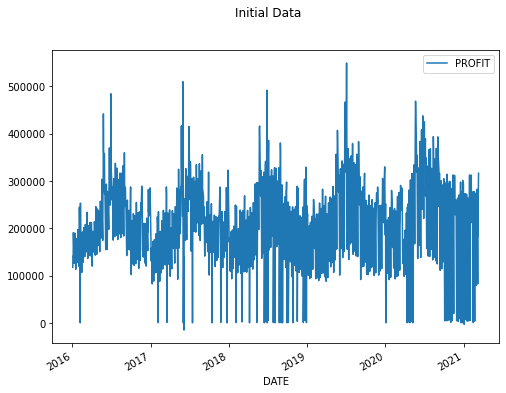

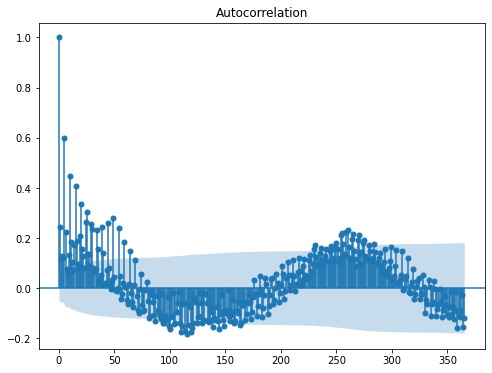

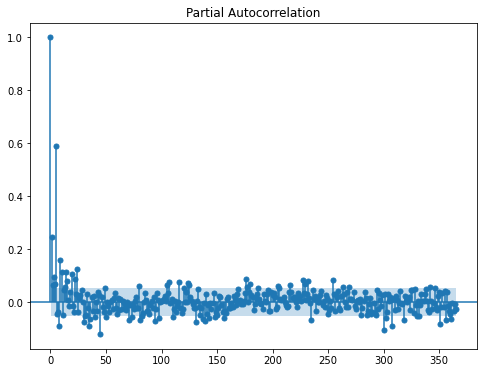

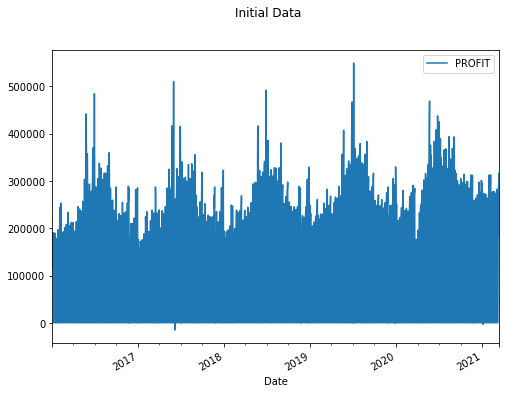

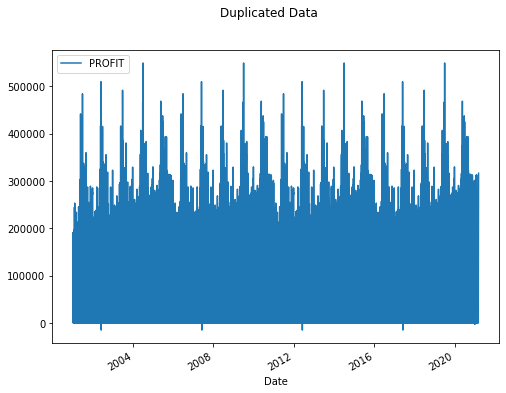

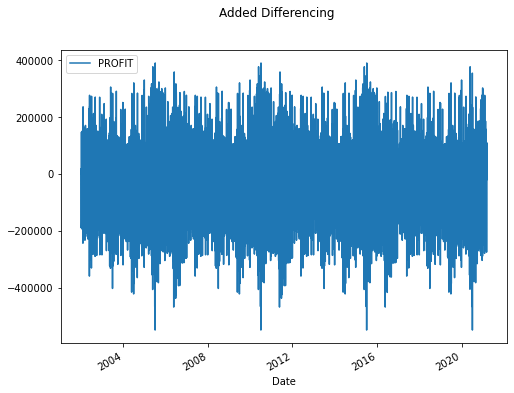

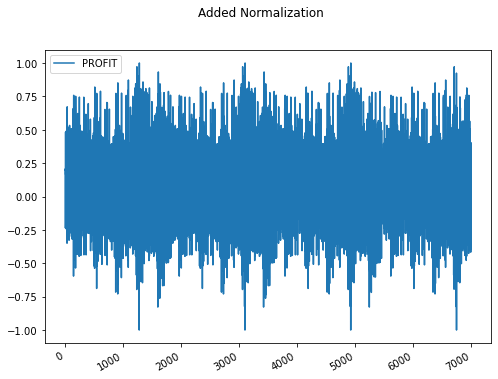

In [7]:
obj = schema_ML(schema, features)

(6167, 1, 3)
Epoch 1/500
193/193 - 12s - loss: 0.1057 - val_loss: 0.0784
Epoch 2/500
193/193 - 1s - loss: 0.0800 - val_loss: 0.0774
Epoch 3/500
193/193 - 2s - loss: 0.0800 - val_loss: 0.0768
Epoch 4/500
193/193 - 1s - loss: 0.0799 - val_loss: 0.0769
Epoch 5/500
193/193 - 2s - loss: 0.0799 - val_loss: 0.0766
Epoch 6/500
193/193 - 1s - loss: 0.0799 - val_loss: 0.0764
Epoch 7/500
193/193 - 2s - loss: 0.0799 - val_loss: 0.0762
Epoch 8/500
193/193 - 1s - loss: 0.0799 - val_loss: 0.0764
Epoch 9/500
193/193 - 1s - loss: 0.0799 - val_loss: 0.0766
Epoch 10/500
193/193 - 2s - loss: 0.0799 - val_loss: 0.0765
Epoch 11/500
193/193 - 2s - loss: 0.0799 - val_loss: 0.0764
Epoch 12/500
193/193 - 2s - loss: 0.0798 - val_loss: 0.0765


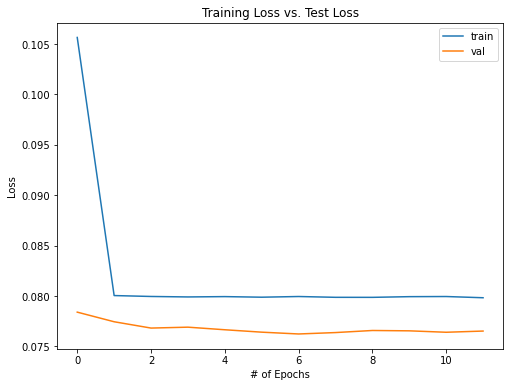

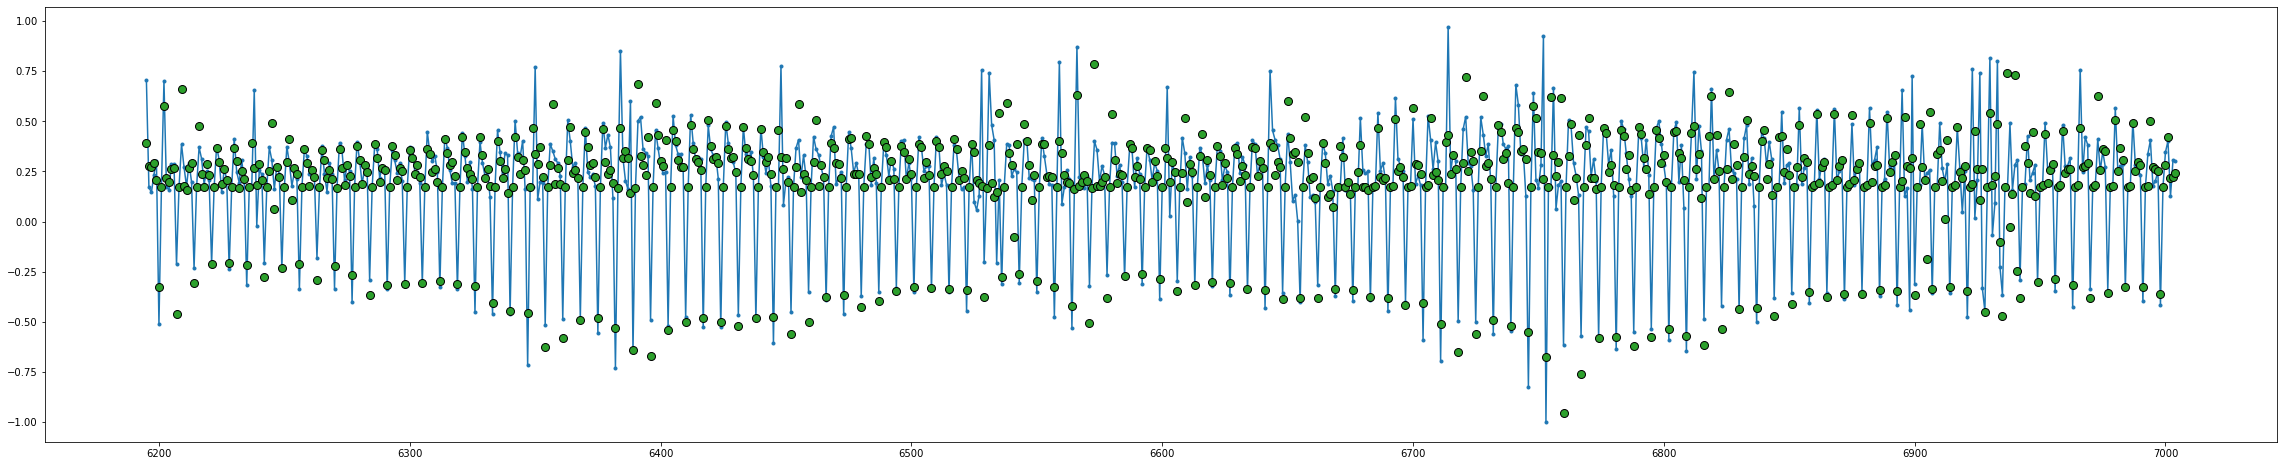

In [8]:
 X_train, Y_train, X_test, Y_test = obj.get_train_and_test('PROFIT')
print(X_train.shape)

MONITOR = 'val_loss'
PATIENCE = 5
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'Base LSTM'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(365),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


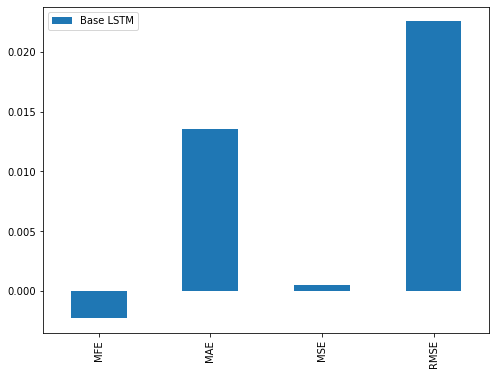

      Base LSTM
MFE   -0.002275
MAE    0.013556
MSE    0.000508
RMSE   0.022544


In [60]:
obj.performance_metrics()